In [1]:
import csv
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle


Using TensorFlow backend.


In [2]:
DS = pd.read_csv("DataAnnotatedSubset150SentenceLength.csv")

In [3]:
DS['tag'].fillna('text', inplace=True)

In [4]:
words = list(set(DS["word"].values))
n_words = len(words)
n_words

27741

In [5]:
tags = list(set(DS["tag"].values))
n_tags = len(tags); n_tags


3

In [6]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("text_ID").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [7]:
getter = SentenceGetter(DS)

In [8]:
sentences = getter.sentences


In [9]:
sentences[1]

[('Pt.', 'text'),
 ('tehtud', 'text'),
 ('3', 'text'),
 ('plasmaferees,', 'text'),
 ('talus', 'text'),
 ('hästi.', 'text'),
 ('Eemaldatud', 'text'),
 ('700', 'text'),
 ('ml', 'text'),
 ('plasmat.', 'text'),
 ('RR', 'object'),
 ('112/60', 'value'),
 ('mmHg.', 'text'),
 ('Tgasi', 'text'),
 ('22.10.09.', 'text')]

In [10]:
# np.median([len(s) for s in sentences])
DS.word.apply(lambda x: len(x)).describe()

count    157280.000000
mean          6.230697
std           4.330117
min           1.000000
25%           3.000000
50%           5.000000
75%           9.000000
max          54.000000
Name: word, dtype: float64

In [11]:
LengthsList = []
for i in range(len(sentences)):
    LengthsList.append(len(sentences[i]))
np.max(LengthsList)

150

In [12]:
sentences[6]

[('Kokkuvõte:', 'text'),
 ('<ANONYM', 'text'),
 ('id="0"', 'text'),
 ('type="per"', 'text'),
 ('morph="_A_', 'text'),
 ('sg', 'text'),
 ('n"/>', 'text'),
 ('nähtava', 'text'),
 ('patoloogiata.', 'text'),
 ('Kokkuvõte:', 'text'),
 ('<ANONYM', 'text'),
 ('id="0"', 'text'),
 ('type="per"', 'text'),
 ('morph="_A_', 'text'),
 ('sg', 'text'),
 ('n"/>', 'text'),
 ('nähtava', 'text'),
 ('patoloogiata.', 'text'),
 ('Kokkuvõte:', 'text'),
 ('<ANONYM', 'text'),
 ('id="0"', 'text'),
 ('type="per"', 'text'),
 ('morph="_A_', 'text'),
 ('sg', 'text'),
 ('n"/>', 'text'),
 ('nähtava', 'text'),
 ('patoloogiata.', 'text'),
 ('Kokkuvõte:', 'text'),
 ('<ANONYM', 'text'),
 ('id="0"', 'text'),
 ('type="per"', 'text'),
 ('morph="_A_', 'text'),
 ('sg', 'text'),
 ('n"/>', 'text'),
 ('nähtava', 'text'),
 ('patoloogiata.', 'text'),
 ('Kokkuvõte:', 'text'),
 ('<ANONYM', 'text'),
 ('id="0"', 'text'),
 ('type="per"', 'text'),
 ('morph="_A_', 'text'),
 ('sg', 'text'),
 ('n"/>', 'text'),
 ('nähtava', 'text'),
 ('patol

In [13]:
max_len = 150
max_len_char = 10

In [14]:
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [15]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)


104


In [16]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1 #For predictions
char2idx["PAD"] = 0

In [17]:
idx2char = {i: w for w, i in char2idx.items()}

In [18]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [19]:
y = [[tag2idx[w[1]] for w  in s] for s in sentences]


In [20]:
len(sentences)

13643

In [21]:
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')


In [22]:
from sklearn.model_selection import train_test_split
X_char_tr, X_char_te, y_tr,  y_te= train_test_split(X_char, y, test_size=0.2, random_state=2018)


In [23]:
# hidden_nodes = int(2/3 * (max_len * max_len_char))
# print(f"The number of hidden nodes is {hidden_nodes}.")


In [24]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D


# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = SpatialDropout1D(0.3)(char_enc)
main_lstm = Bidirectional(LSTM(units=20, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_lstm)

model = Model( char_in, out)




In [25]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 10)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 150, 10, 10)       1060      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 150, 20)           2480      
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 20)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 40)           6560      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 150, 4)            164       
Total params: 10,264
Trainable params: 10,264
Non-trainable params: 0
_______________________________________________________

In [26]:
history = model.fit(np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char)),
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.1, verbose=1)


C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9822 samples, validate on 1092 samples
Epoch 1/10
9822/9822 [==============================] - 67s 7ms/step - loss: 0.0332 - acc: 0.8945 - val_loss: 0.0136 - val_acc: 0.9447
Epoch 2/10
9822/9822 [==============================] - 70s 7ms/step - loss: 0.0105 - acc: 0.9658 - val_loss: 0.0075 - val_acc: 0.9775
Epoch 3/10
9822/9822 [==============================] - 68s 7ms/step - loss: 0.0065 - acc: 0.9800 - val_loss: 0.0042 - val_acc: 0.9872
Epoch 4/10
9822/9822 [==============================] - 67s 7ms/step - loss: 0.0046 - acc: 0.9859 - val_loss: 0.0034 - val_acc: 0.9898
Epoch 5/10
9822/9822 [==============================] - 70s 7ms/step - loss: 0.0039 - acc: 0.9878 - val_loss: 0.0030 - val_acc: 0.9906
Epoch 6/10
9822/9822 [==============================] - 68s 7ms/step - loss: 0.0035 - acc: 0.9886 - val_loss: 0.0028 - val_acc: 0.9906
Epoch 7/10
9822/9822 [==============================] - 66s 7ms/step - loss: 0.0033 - acc: 0.9891 - val_loss: 0.0027 - val_acc: 0.9914
Epoch 8

In [27]:
hist = pd.DataFrame(history.history)


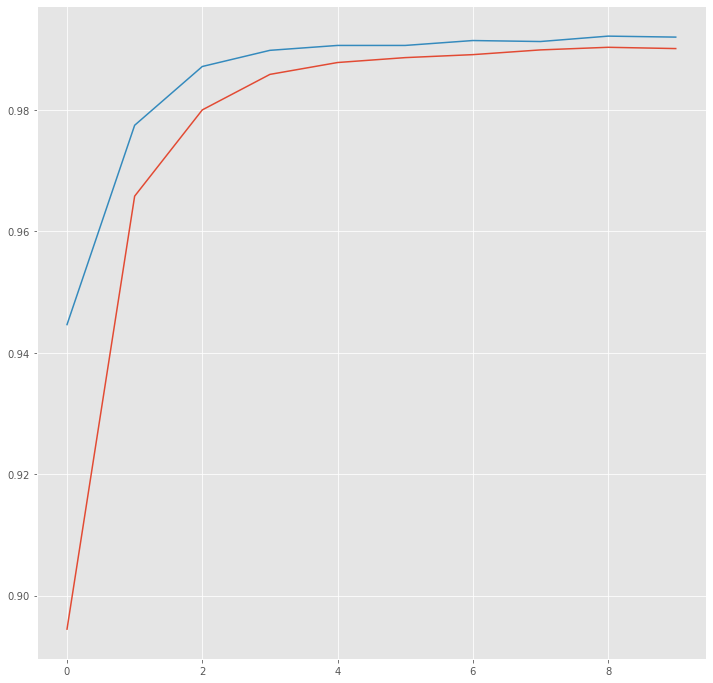

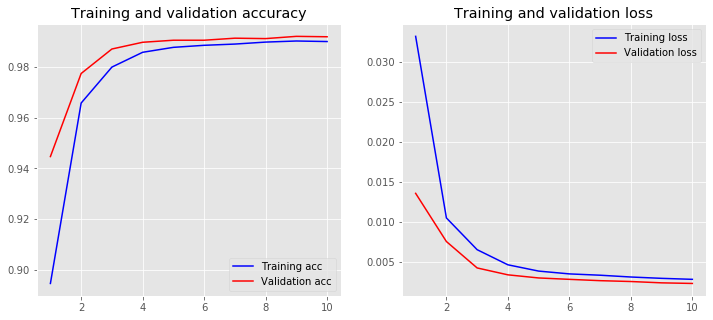

In [28]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()


# Plot the graph 
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)



In [29]:
y_pred = model.predict(
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char)))


In [30]:
def charindx2word(Tword):
    word = []
    for i in range(len(Tword)):
        if(Tword[i] !=0):
            word.append(idx2char[Tword[i]])
    return "".join(word)

In [31]:
i = 1000
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_char_te[i], y_te[i], p):
    if t != 0: #PAD
        print("{:15}: {:5} {}".format(charindx2word(w), idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
Üldseisnud     : text  text
rahuldav.S     : text  text
regulaarne     : object text
mm             : text  text
Hg.Vesikul     : text  text
hingamiska     : text  text
pehme,valu     : text  text


In [32]:
i = 14
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_char_te[i], y_te[i], p):
    if t != 0: #PAD
        print("{:15}: {:5} {}".format(charindx2word(w), idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
Üldseisnud     : text  text
rahuldav.S     : text  text
ebaregulaa     : object text
mm             : text  text
Hg.Vesiula     : text  text
hingamiska     : text  text
pehme,valu     : text  text


In [33]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p, axis=-1)
#             out_i.append(idx2tag[p_i])
            out_i.append(idx2tag[p_i].replace("PAD", "text"))

        out.append(out_i)
    return out
pred_labels = pred2label(y_pred)

def pred2labelV2(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
#             out_i.append(idx2tag[p])
            out_i.append(idx2tag[p].replace("PAD", "text"))

        out.append(out_i)
    return out
test_labels = pred2labelV2(y_te)

In [34]:
from seqeval.metrics import accuracy_score,precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 89.6%


In [35]:
from sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

              precision    recall  f1-score   support

      object       0.14      0.93      0.24      2075
        text       1.00      0.92      0.96    405697
       value       0.06      0.91      0.12      1578

    accuracy                           0.92    409350
   macro avg       0.40      0.92      0.44    409350
weighted avg       0.99      0.92      0.95    409350



In [36]:
print(classification_report(test_labels,pred_labels))

           precision    recall  f1-score   support

     text       0.94      0.87      0.90      4461
   object       0.95      0.89      0.92      2064
    value       0.88      0.82      0.85      1577

micro avg       0.93      0.86      0.90      8102
macro avg       0.93      0.86      0.90      8102



In [39]:
j = 0
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")

for i in range(len(y_pred)):
    p = np.argmax(y_pred[i], axis=-1)
    for w, t, pred in zip(X_char_te[i], y_te[i], p):
        if charindx2word(w) != "": #PAD
            if idx2tag[t] != idx2tag[pred]:
                print("{:15}: {:5} {}".format(charindx2word(w), idx2tag[t], idx2tag[pred]))
                j = j+1
                
                


Word           ||True ||Pred
/106           : text  value
90             : text  value
ebaregulaa     : object text
160cm          : text  value
Pikkus         : object text
157            : value text
Pikkus         : object text
KORRAS.        : object text
KOORMUSTES     : object text
155/95         : value text
24-tunni       : value text
Pikkus-174     : object text
Nõustamine     : object text
=              : text  value
kõikumised     : object text
140-90mmhg     : value text
100            : text  value
sööki-6,6m     : object text
regulaarne     : object text
Pikkus-        : object text
178            : value text
kaebusteta     : object text
regulaarne     : object text
Pikkus:        : object text
162,7cm        : value text
Pikkus:        : object text
162,7cm        : value text
tarvitanud     : object text
135/82         : value text
139.0/85.7     : value text
139.0/85.7     : value text
139.0/85.7     : value text
Pikkus         : object text
164            : value te

In [40]:
j

325

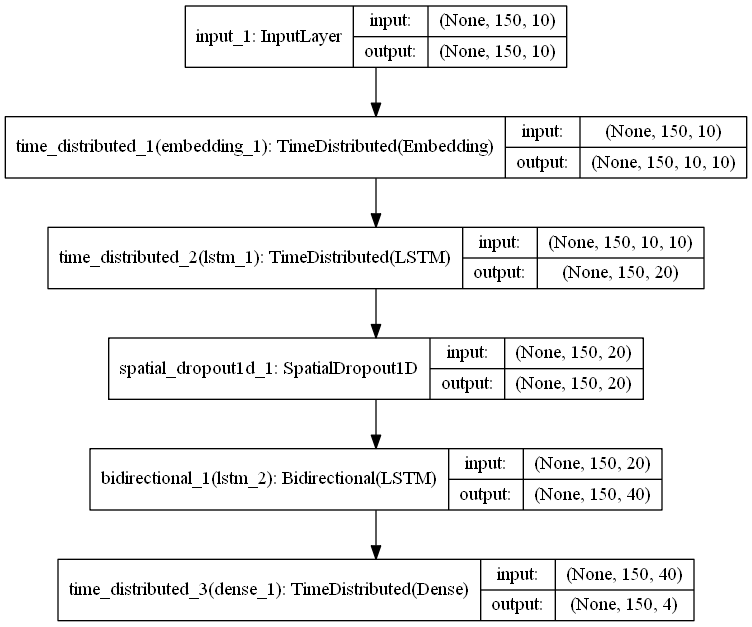

In [41]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='ObjValue_plot.png', show_shapes=True, show_layer_names=True)